In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import glob
import os.path
import pandas as pd
import numpy as np
import matplotlib as mpl
import gc_colors
mpl.rcParams["figure.figsize"] = 15, 12
mpl.rcParams["lines.markeredgewidth"] = 1.0

# Function definitions

In [223]:
def get_medians(data, n_parts=4):
    """Helper function for median uniformity."""
    datablocks = np.split(np.asarray(data), n_parts)
    medians = []
    for block in datablocks:
        medians.append(np.median(block))
        
    return medians

def median_uniformity(data, n_parts=4):
    """Split data in n_parts, calc median for each split and return the ratio of the min(medians)/max(medians).
    A larger value translates to a better uniformity!"""
    medians = np.asarray(get_medians(data, n_parts))
    
    #Remove one outlier
    #median_of_medians = np.median(medians)
    #abs_distance = np.abs(medians - median_of_medians)
    #medians = medians[np.arange(len(medians))!=np.argmax(abs_distance)]
    
    return min(medians)/max(medians)


def get_means(data, n_parts=4):
    """Helper function for median uniformity."""
    datablocks = np.split(np.asarray(data), n_parts)
    means = []
    for block in datablocks:
        means.append(np.mean(block))
        
    return means

def mean_uniformity(data, n_parts=4):
    """Split data in n_parts, calc median for each split and return the ratio of the min(medians)/max(medians).
    A larger value translates to a better uniformity!"""
    means = np.asarray(get_means(data, n_parts))
    
    #Remove one outlier
    #median_of_medians = np.median(medians)
    #abs_distance = np.abs(medians - median_of_medians)
    #medians = medians[np.arange(len(medians))!=np.argmax(abs_distance)]
    
    return min(means)/max(means)



#Load files========================================================================================================
def arduino2pandas(path):
    not_in_production = os.path.join(path, "HD*.csv")
    in_production = os.path.join(path, "In_Production/HD*.csv")
    arduino_files = glob.glob(not_in_production)  #Bars on my desk
    arduino_files_production = glob.glob(in_production)  #Bars in production
    print("Found {0} ({1}) arduino data files in '{2}/' ('{3}/')".format(len(arduino_files), 
                                                                         len(arduino_files_production),
                                                                         os.path.dirname(not_in_production), 
                                                                         os.path.dirname(in_production)))
    lightbar_dict = {}    #Dict containing the data (as pandas DataFrame) with lightbar name as key (e.g. "HD70")
    for in_production, files in enumerate([arduino_files, arduino_files_production]):
        for filename in files:
            lightbar = os.path.splitext(os.path.basename(filename))[0]    #Lightbar name (e.g "HD70")
            lightbar_nr = int(lightbar[2:])
            arduino_data = pd.read_csv(filename, delim_whitespace=True, comment='#', names=["Ch", "Blue", "Red"])
            if (arduino_data["Red"] < 0).all():
                data = arduino_data["Blue"].values
            else:
                data = arduino_data["Red"].values
            lightbar_dict[lightbar_nr] = { "Has_Arduino" : 1, "Arduino_Data_VEC" : data, 
                                           "Arduino_In_Production" : in_production }
            
    #Convert to pandas DataFrame
    df = pd.DataFrame(lightbar_dict).transpose()
    df["Lightbar"] = df.index
    
    return df



def mattest2pandas(path):
    not_in_production = os.path.join(path, "HD*.csv")
    in_production = os.path.join(path, "In_Production/HD*.csv")
    mattest_files = glob.glob(not_in_production)  #Bars on my desk
    mattest_files_production = glob.glob(in_production)  #Bars in production
    print("Found {0} ({1}) mattest data files in '{2}/' ('{3}/')".format(len(mattest_files), 
                                                                         len(mattest_files_production),
                                                                         os.path.dirname(not_in_production), 
                                                                         os.path.dirname(in_production)))
    #Read uniformity file if available
    uniformity_file = glob.glob(os.path.join(path, "Uniformity.txt"))
    if uniformity_file:
        uniformity_file = uniformity_file[0]
        print("Found uniformity file: {0}".format(uniformity_file))

    uniformity_df = pd.read_csv("Lightuniformity_Meas/Mattest/Uniformity.txt", names=["Lightbar", "Uniformity"], 
                           delim_whitespace=True, comment="#")
    uniformity_df.index = np.asarray(uniformity_df["Lightbar"])

    lightbar_dict = {}    #Dict containing the data (as pandas DataFrame) with lightbar name as key (e.g. "HD70")
    for in_production, files in enumerate([mattest_files, mattest_files_production]):
        for filename in files:
            lightbar = os.path.splitext(os.path.basename(filename))[0]    #Lightbar name (e.g "HD70")
            lightbar_nr = int(lightbar[2:-5])
            led_brightness = int(lightbar[-2:])
            has_uniformity = int(lightbar_nr in uniformity_df["Lightbar"])
            if has_uniformity:
                uniformity = uniformity_df.loc[lightbar_nr]["Uniformity"]
            else:
                uniformity = "NA"
            mattest_data = pd.read_csv(filename, sep=";", skiprows=15, names=["Ch", "Pedestal", "Gain", "Mean_pixels"])
            lightbar_dict[lightbar_nr] = { "Has_Mattest" : 1,
                                           "Mattest_Data_VEC" : mattest_data["Mean_pixels"].values,
                                           "Mattest_Gain_VEC" : mattest_data["Gain"].values,
                                           "Mattest_Pedestal_VEC" : mattest_data["Pedestal"].values,
                                           "Mattest_Brightness" : led_brightness,
                                           "Mattest_In_Production" : in_production,
                                           "Mattest_Has_Uniformity" : has_uniformity,
                                           "Mattest_Uniformity" : uniformity }
            
    #Convert to pandas DataFrame
    df = pd.DataFrame(lightbar_dict).transpose()
    df["Lightbar"] = df.index
    
    return df



#Merge DataFrames==== =================================================================================================
def merge_arduino_mattest(arduino_df, mattest_df):
    merged_df = pd.concat([arduino_df, mattest_df.drop("Lightbar", 1)], 1)
    for has in ["Has_Arduino", "Has_Mattest", "Mattest_Has_Uniformity"]:
        merged_df[has] = merged_df[has].fillna(0)
    
    #Check for In_Production consistency and create new (common) column
    merged_df["In_Production"] = -1
    for bar, ard_prod, mat_prod in merged_df[ ["Lightbar", "Arduino_In_Production", "Mattest_In_Production"] ].values:
        if np.isnan(ard_prod) and np.isnan(mat_prod):
            raise ValueError("No 'In_Production' entry found for lightbar {0}".format(bar))
        elif not np.isnan(ard_prod):
             merged_df.set_value(bar, 'In_Production', ard_prod)
        elif not np.isnan(mat_prod):
             merged_df.set_value(bar, 'In_Production', mat_prod)
        else:
            if ard_prod == mat_prod:
                merged_df.set_value(bar, 'In_Production', ard_prod)
            else:
                raise ValueError("Inconsistency in 'In_Production' data for lightbar {0}".format(bar))
    
    return merged_df.drop(["Arduino_In_Production", "Mattest_In_Production"], 1)

# Load the necessary files and containing data

In [227]:
arduino_df = arduino2pandas("Lightuniformity_Meas/LED5_INT50/")
mattest_df = mattest2pandas("Lightuniformity_Meas/Mattest/")

df = merge_arduino_mattest(arduino_df, mattest_df)

Found 29 (24) arduino data files in 'Lightuniformity_Meas/LED5_INT50/' ('Lightuniformity_Meas/LED5_INT50/In_Production/')
Found 13 (24) mattest data files in 'Lightuniformity_Meas/Mattest/' ('Lightuniformity_Meas/Mattest/In_Production/')
Found uniformity file: Lightuniformity_Meas/Mattest/Uniformity.txt


# Correct the strange step in the mattest data

In [43]:
n = 10 #Number of median values to take for calc. the steps
df["Mattest_Stepfactor"] = -10.
for i, row in df.iterrows():
    try:
        data = np.array(row["Mattest_Data"]["Mean_pixels"])
    except:
        continue
    idx = 256
    stepfactor_low = np.median(data[idx-n:idx])/np.median(data[idx:idx+10])
    idx = 384
    stepfactor_up = np.median(data[idx:idx+n])/np.median(data[idx-n:idx])
    stepfactor = (stepfactor_low+stepfactor_up)/2
    data[256:384] = data[256:384] * stepfactor
    row["Mattest_Data"]["Mean_pixels_corrected"] = data
    df.set_value(i, 'Mattest_Stepfactor', stepfactor)

# Add mean and rel. std to the dataframe

In [44]:
df["Arduino_Mean"] = -10.
df["Arduino_Rel_Std"] = -10.
df["Mattest_Mean"] = -10.
df["Mattest_Rel_Std"] = -10.

for i, row in df.iterrows():
    print()
    arduino_data = row["Arduino_Data"]["Red"]
    arduino_mean = np.mean(arduino_data)
    arduino_std = np.std(arduino_data)
    df.set_value(i, "Arduino_Mean", arduino_mean)
    df.set_value(i, "Arduino_Rel_Std", arduino_std/arduino_mean)
    
    
    try:
        mattest_data = row["Mattest_Data"]["Mean_pixels_corrected"]
        mattest_mean = np.mean(mattest_data)
        mattest_std = np.std(mattest_data)
        df.set_value(i, "Mattest_Mean", mattest_mean)
        df.set_value(i, "Mattest_Rel_Std", mattest_std/mattest_mean)
    except:
        pass

# Calculate a different variable for the light uniformity

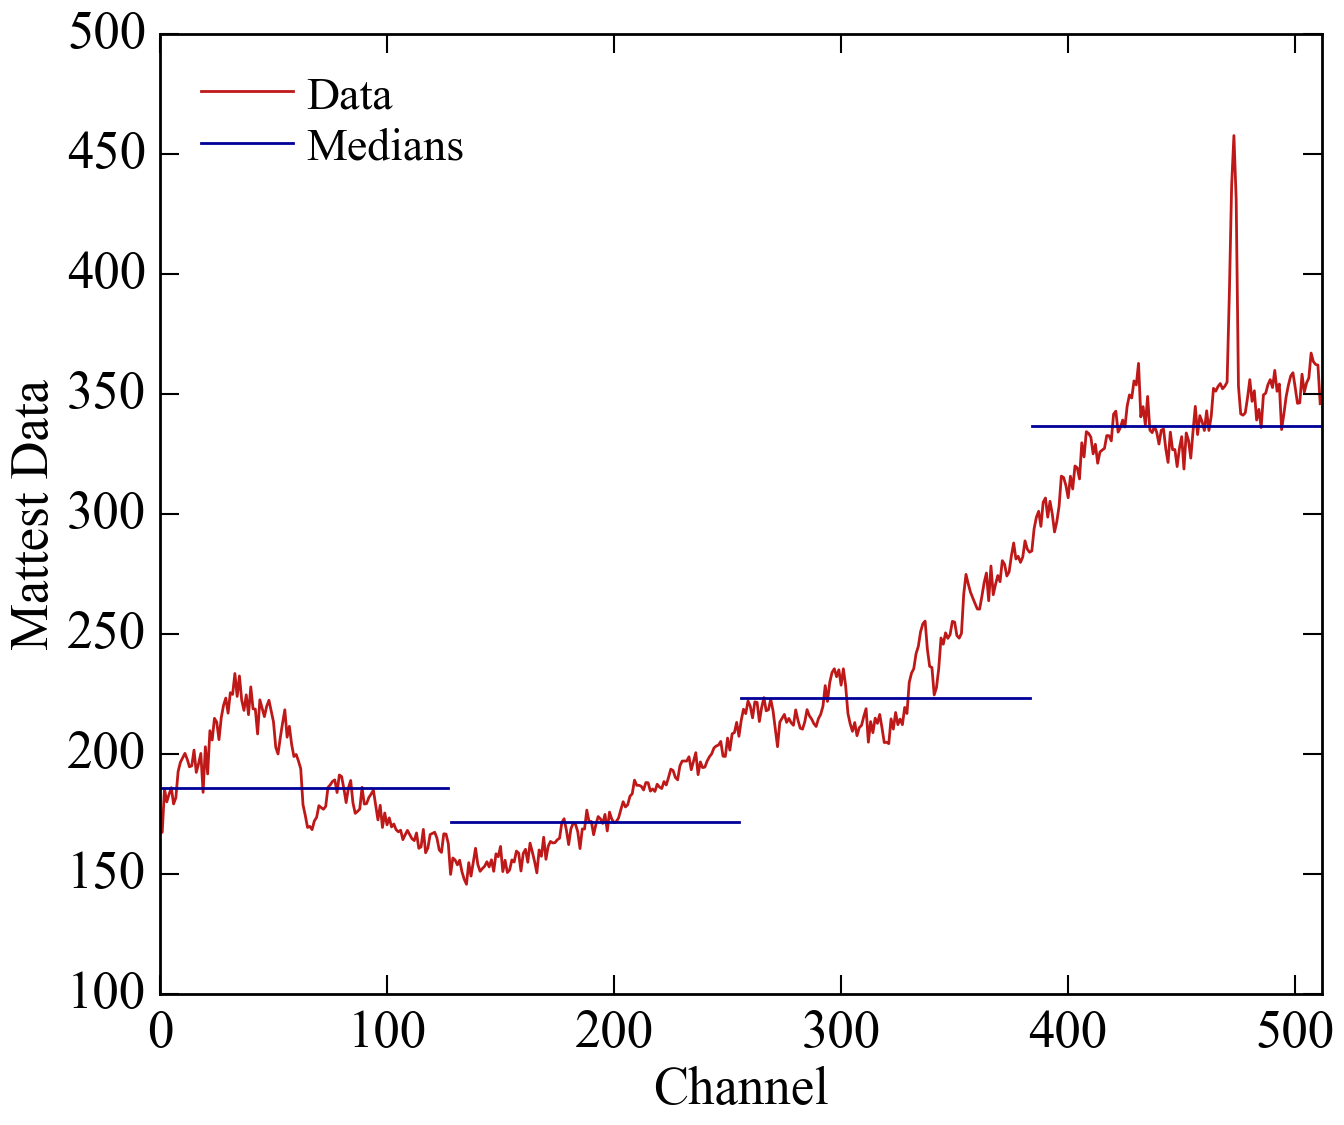

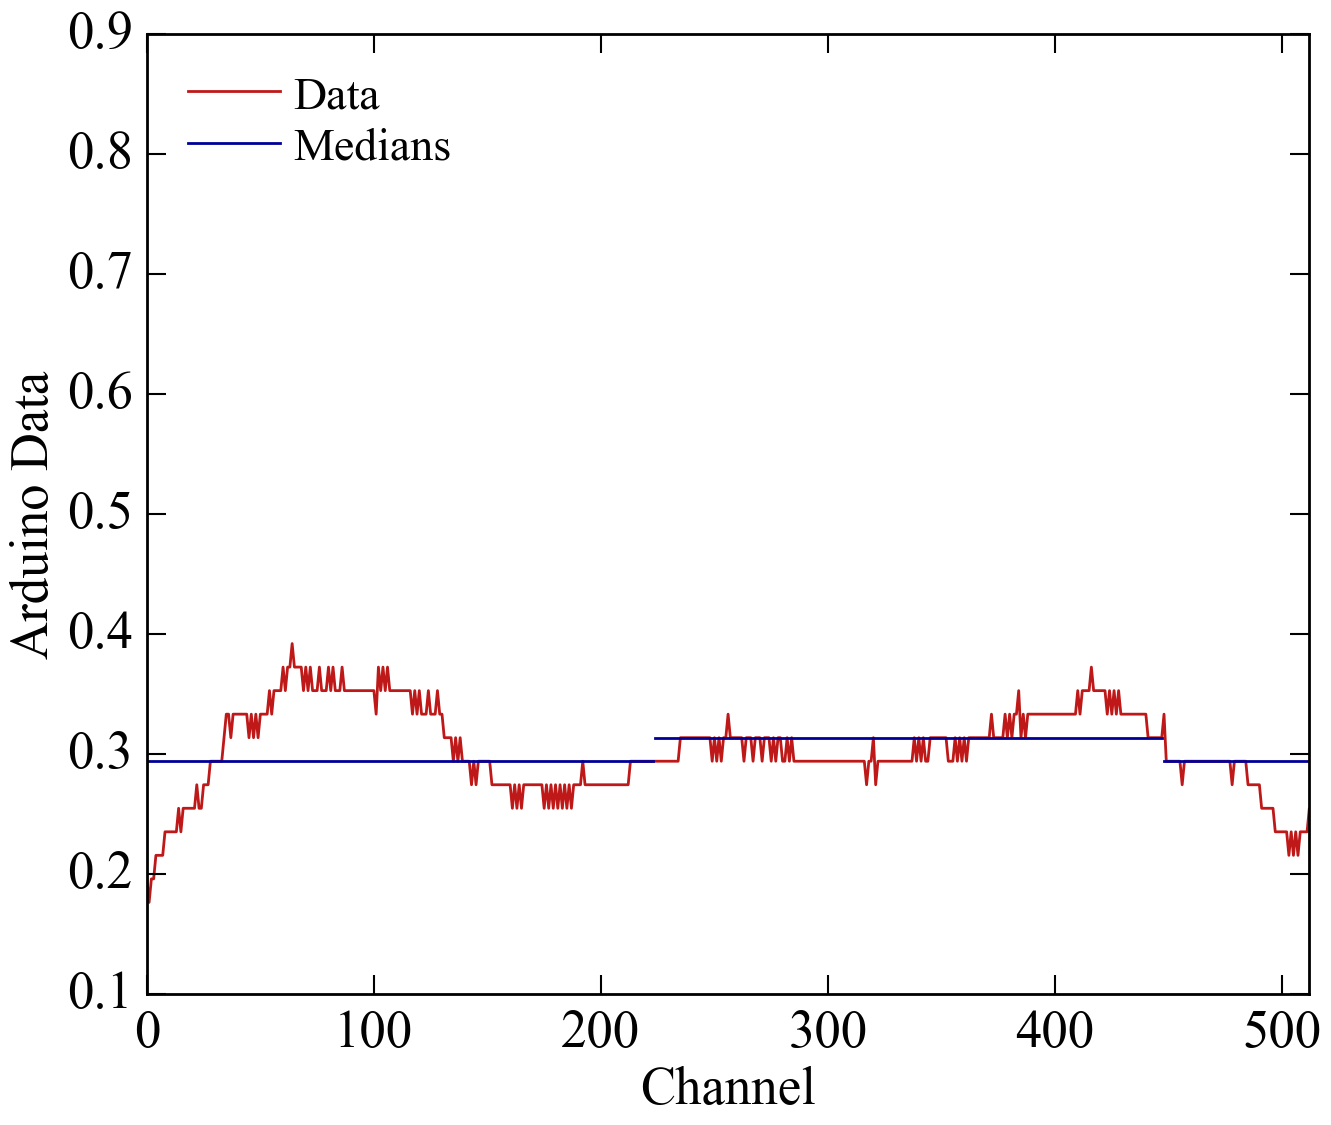

In [45]:
n_parts = 4

df["Mattest_Median_Uniformity"] = -10.
df["Arduino_Median_Uniformity"] = -10.
for i, row in df.iterrows():
    data_arduino = np.array(row["Arduino_Data"]["Red"])
    arduino_uniformity = mean_uniformity(data_arduino, n_parts)
    df.set_value(i, "Arduino_Median_Uniformity", arduino_uniformity)


    try:
        data_mattest = np.array(row["Mattest_Data"]["Mean_pixels_corrected"])
        mattest_uniformity = mean_uniformity(data_mattest, n_parts)
        df.set_value(i, "Mattest_Median_Uniformity", mattest_uniformity)
    except TypeError:
        pass
    

#Control plot
lightbar = 71
data_mattest = df.loc[lightbar]["Mattest_Data"]["Mean_pixels_corrected"]
data_arduino = df.loc[lightbar]["Arduino_Data"]["Red"]

for idx, data in enumerate([data_mattest, data_arduino]):
    medians = get_medians(data, n_parts)
    xticks = np.split(np.asarray(range(len(data))), n_parts)

    plt.plot(range(len(data)), data, "gcred", label="Data")
    for i in range(n_parts):
        if i == 0:
            plt.plot([xticks[i][0], xticks[i][-1]], [medians[i], medians[i]], "gcblue", label = "Medians")
            plt.xlim(0,512)
        else:
            plt.plot([xticks[i][0], xticks[i][-1]], [medians[i], medians[i]], "gcblue")
    plt.xlabel("Channel")    
    if idx == 0:
        plt.ylabel("Mattest Data")
    elif idx == 1:
        plt.ylabel("Arduino Data")
    plt.legend(loc = "upper left")
    plt.show()
    plt.close()

# Plots

### Arduino mean vs. LED brightness of mattest measurement

(37, 50)

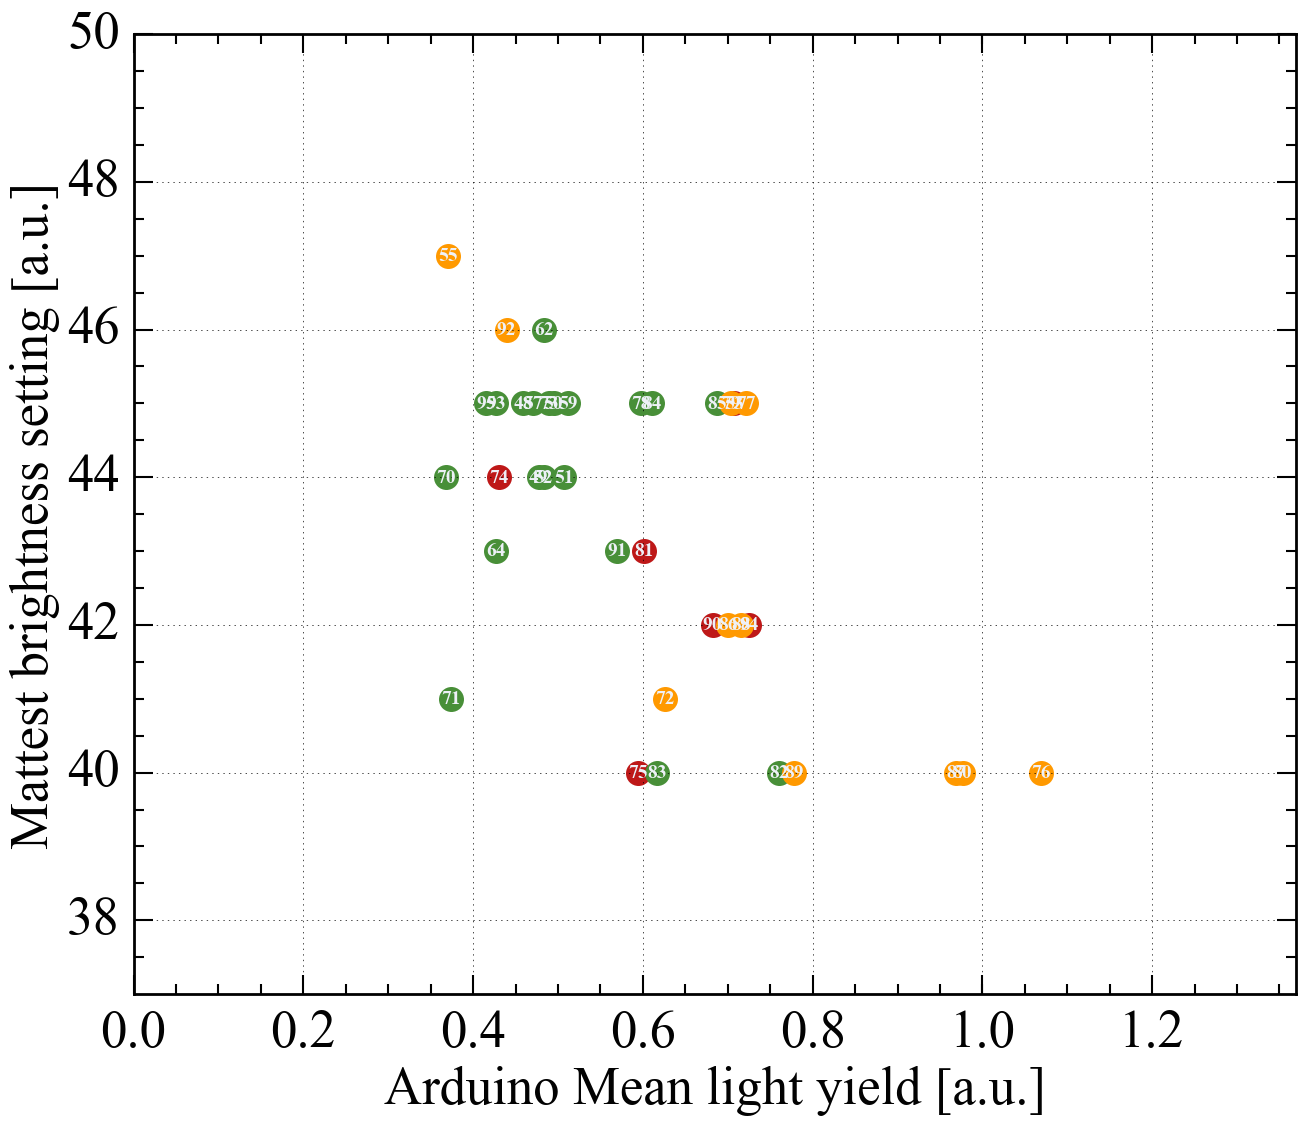

In [8]:
xcolumn = "Arduino_Mean"
ycolumn = "Mattest_Brightness"

uniformity_colors = {"bad" : "gcred", "ok" : "gcorange", "good" : "gcgreen"}

#Plot in different colors
for key, value in uniformity_colors.iteritems():
    datapart = df.loc[ df["Uniformity"] == key ]
    line2d = plt.plot( datapart[xcolumn], datapart[ycolumn], 
                       color=value, marker="o", lw=0, mew=0, ms=18)[0]

#Plot numbers
for x,y, lightbar_nr in df[ [xcolumn, ycolumn, "Lightbar"] ].values:
    plt.text(x,y, int(lightbar_nr), ha="center", va="center", color="gcsilver", weight="heavy")

plt.minorticks_on()
plt.grid()

plt.xlabel("Arduino Mean light yield [a.u.]")
plt.ylabel("Mattest brightness setting [a.u.]")

plt.xlim(0,max(df[xcolumn]) + 0.3)
plt.ylim(min(df[ycolumn]) - 3, max(df[ycolumn]) + 3)


### Arduino rel. std vs. mattest rel. std

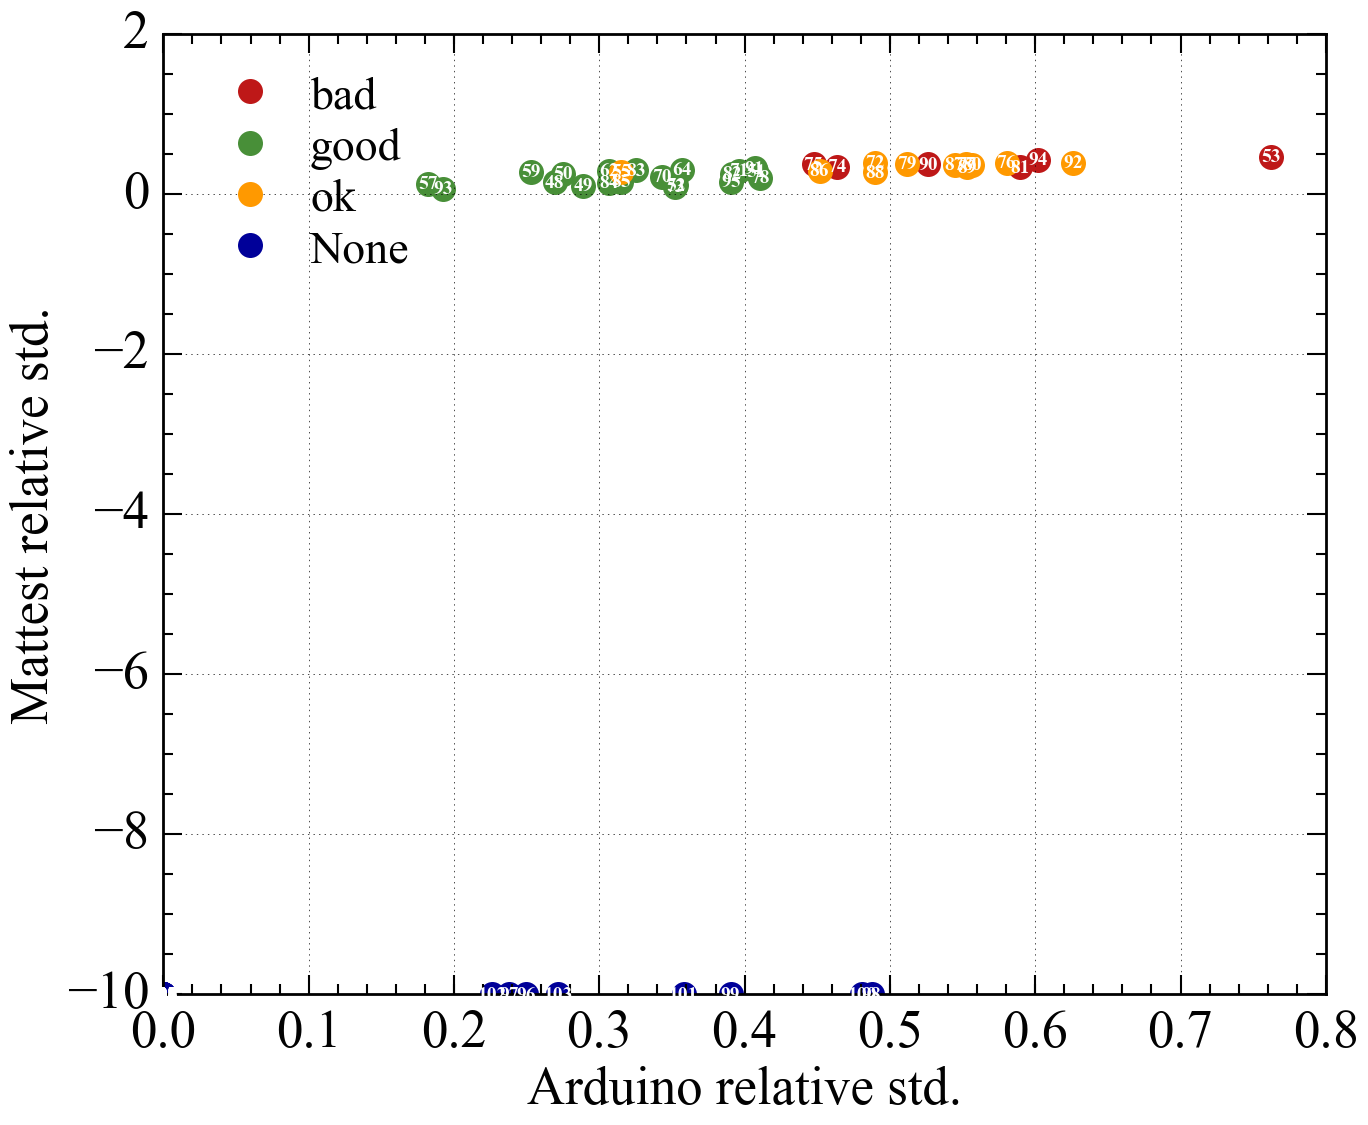

In [46]:
uniformity_colors = {"bad" : "gcred", "ok" : "gcorange", "good" : "gcgreen", "None" : "gcblue"}

#Plot in different colors
for key, value in uniformity_colors.iteritems():
    datapart = df.loc[ df["Uniformity"] == key ]
    if len(datapart) > 0:
        plt.plot( datapart["Arduino_Rel_Std"], datapart["Mattest_Rel_Std"], 
                  color=value, marker="o", lw=0, mew=0, ms=18, label=key)[0]


#Show lightbar IDs    
for x,y, lightbar_nr in df[ ["Arduino_Rel_Std", "Mattest_Rel_Std", "Lightbar"] ].values:
    plt.text(x,y, int(lightbar_nr), ha="center", va="center", color="w", weight="heavy")

plt.legend(loc="upper left")
plt.minorticks_on() 
plt.grid()
#plt.xlim(0, max(df["Arduino_Rel_Std"]) + 0.1)
#plt.ylim(0, max(df["Mattest_Rel_Std"]) + 0.1)
plt.xlabel("Arduino relative std.")
plt.ylabel("Mattest relative std.")

### Arduino median uniformity vs. mattest uniformity

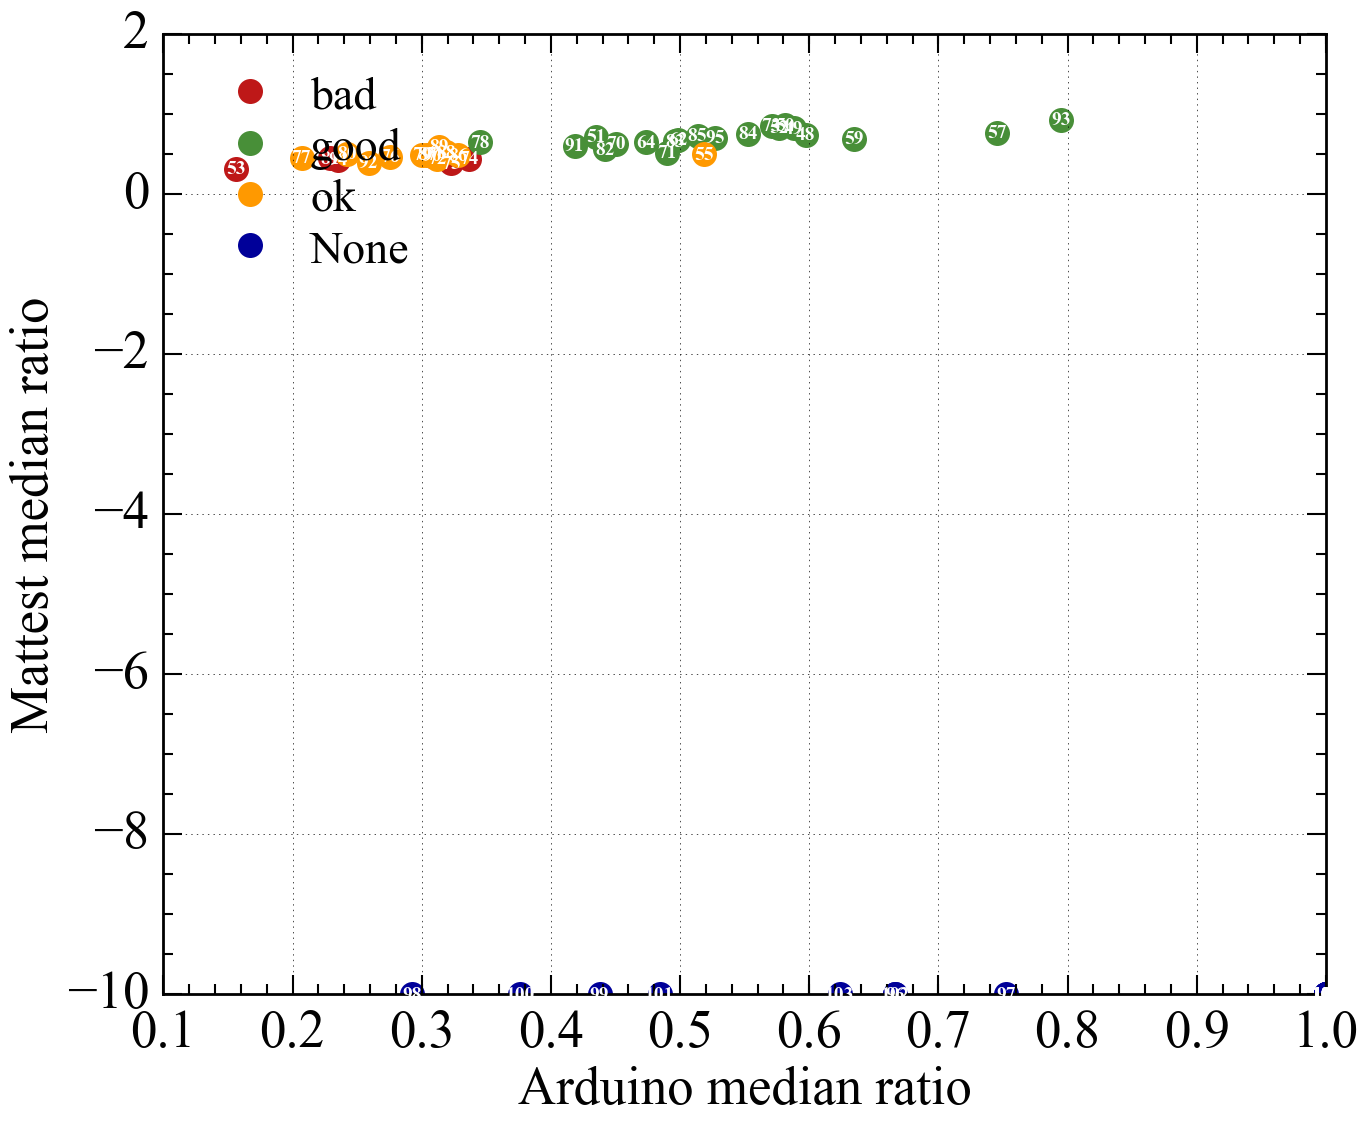

In [47]:
ycolumn = "Mattest_Median_Uniformity"
xcolumn = "Arduino_Median_Uniformity"

uniformity_colors = {"bad" : "gcred", "ok" : "gcorange", "good" : "gcgreen", "None" : "gcblue"}



#Plot in different colors
for key, value in uniformity_colors.iteritems():
    datapart = df.loc[ df["Uniformity"] == key ]
    if len(datapart) > 0:
        plt.plot( datapart[xcolumn], datapart[ycolumn], 
                  color=value, marker="o", lw=0, mew=0, ms=18, label=key)[0]

#Plot numbers
for x,y, lightbar_nr in df[ [xcolumn, ycolumn, "Lightbar"] ].values:
    plt.text(x,y, int(lightbar_nr), ha="center", va="center", color="w", weight="heavy")

plt.legend(loc="upper left")
plt.minorticks_on()
plt.grid()

plt.xlabel("Arduino median ratio")
plt.ylabel("Mattest median ratio")

# Arduino: median uniformity vs. rel std

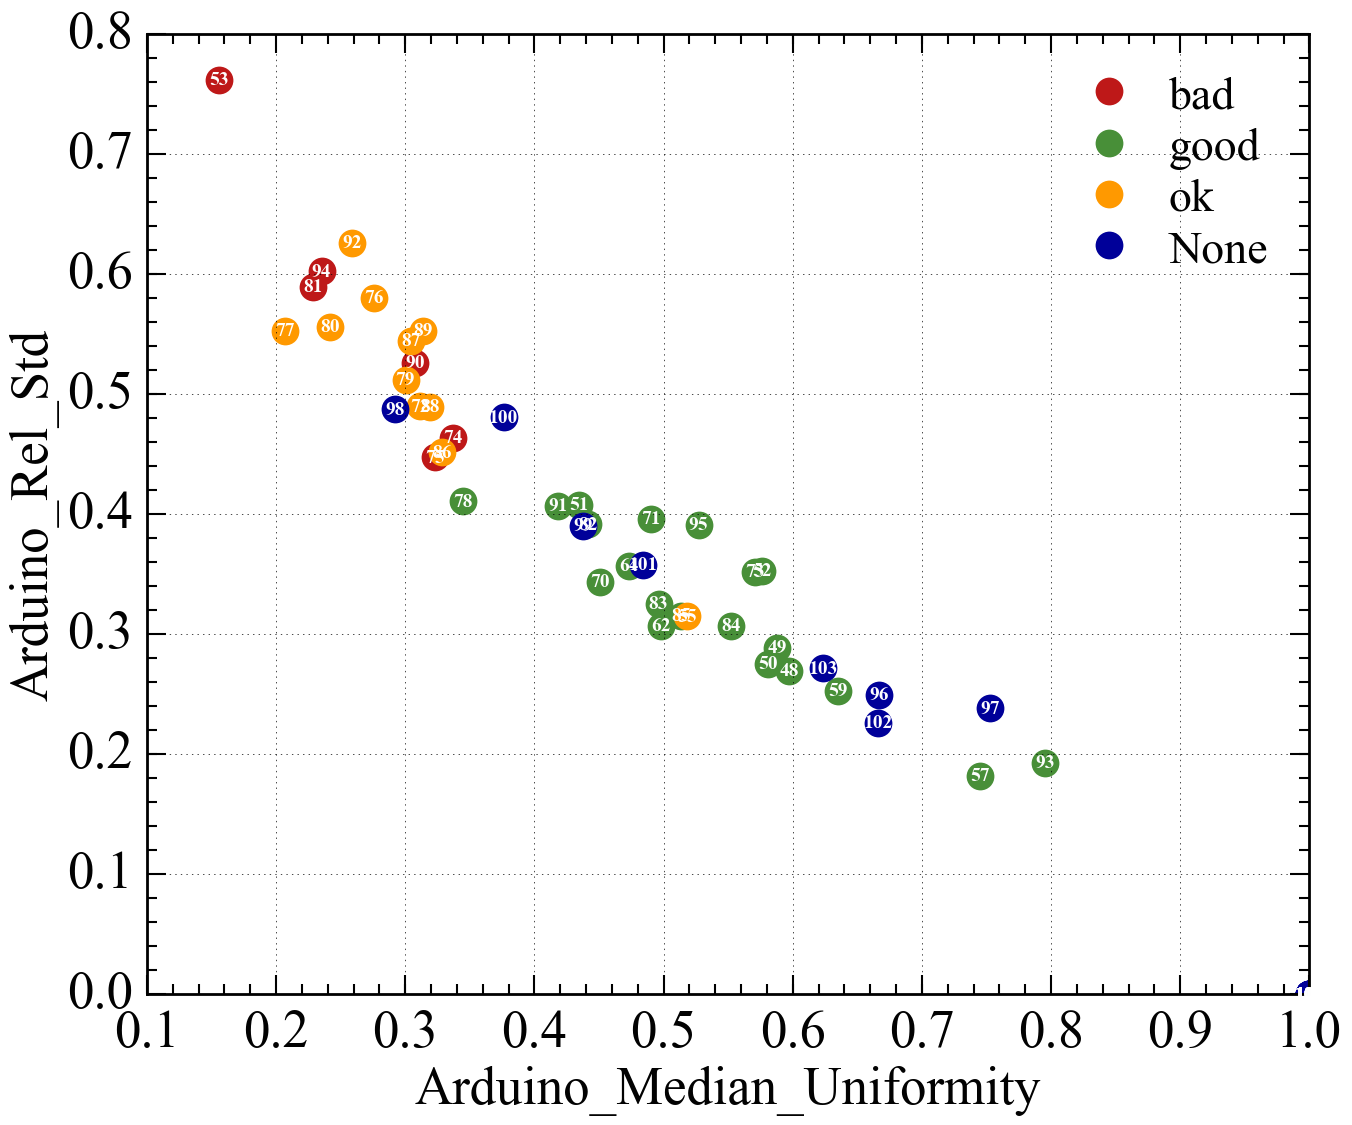

In [49]:
xcolumn = "Arduino_Median_Uniformity"
ycolumn = "Arduino_Rel_Std"

uniformity_colors = {"bad" : "gcred", "ok" : "gcorange", "good" : "gcgreen", "None" : "gcblue"}

#Additional cuts?
#plot_df = df.loc[ df["Uniformity"] != "None" ]
#plot_df = df.loc[ df["In_Production"] == 0 ]
plot_df = df

#Plot in different color
for key, value in uniformity_colors.iteritems():
    datapart = plot_df.loc[ plot_df["Uniformity"] == key ]
    if len(datapart) > 0:
        plt.plot( datapart[xcolumn], datapart[ycolumn], 
                  color=value, marker="o", lw=0, mew=0, ms=20, label=key)[0]

#Plot numbers
for x,y, lightbar_nr in plot_df[ [xcolumn, ycolumn, "Lightbar"] ].values:
    plt.text(x,y, int(lightbar_nr), ha="center", va="center", color="w", weight="heavy")

plt.legend()
plt.minorticks_on()
plt.grid()

plt.xlabel(xcolumn)
plt.ylabel(ycolumn)

In [12]:
df.loc[88]

Arduino_Data                       Ch      Blue       Red
0      0  0.38728...
In_Production                                                                0
Mattest_Brightness                                                          42
Mattest_Data                       Ch  Pedestal   Gain  Mean_pixels  Mean_p...
Lightbar                                                                    88
Uniformity                                                                  ok
Mattest_Stepfactor                                                    0.797905
Arduino_Mean                                                          0.715664
Arduino_Rel_Std                                                       0.489657
Mattest_Mean                                                           276.927
Mattest_Rel_Std                                                       0.273519
Mattest_Median_Uniformity                                             0.523426
Arduino_Median_Uniformity                           